In [1]:
import QUANTAXIS as QA

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['KaiTi', 'SimHei', 'FangSong']  # 汉字字体,优先使用楷体，如果找不到楷体，则使用黑体
mpl.rcParams['font.size'] = 14  # 字体大小
mpl.rcParams['axes.unicode_minus'] = False  # 正常显示负号

import numpy as np

import seaborn as sns

from base.JuUnits import excute_for_multidates
from base.Constants import trade_date_sse, LOW_FREQUENCE
from tools.QAAdapter import QA_adapter_get_blocks
import tools.QAAdapter as qaadapter
import tools.Sample_Tools as smpl

import pandas as pd

class Stock_Trend:
    """
        1.展示每个行业，平均以上的股票占比图
        2.获取变化趋势
    """
    def __init__(self,hy_source='tdxhy', block_name = '软件服务', end='2021-04-30', gap=60, start=None, frequence=QA.FREQUENCE.DAY, MA=20):
        self._hy_source = hy_source
        self.block_name = block_name
        self.end = end
        self.gap = gap
        self.MA = MA
        if start is None:
            self.start = trade_date_sse[trade_date_sse.index(end)-self.gap]
        else:
            self.start = start
        self.blocks_view = self.get_blocks_view()
        self.pivot = None
        self.frequence = frequence
        self.trend = None
                
    @property
    def hy_source(self):
        return self._hy_source
    
    @hy_source.setter
    def hy_source(self, value):
        if not value in ['tdxhy','sw_l1','sw_l2','sw_l3','gn']:
            raise TypeError('hy_source MUST BE [tdxhy|swhy|gn]')
        self._hy_source=value
        self.blocks_view = self.get_blocks_view()
        
    @property
    def is_low_frequence(self):
        return self.frequence in LOW_FREQUENCE

    
    def fit(self, blocks=None):
        if blocks is None or blocks == 'all':
            data = QA.QA_fetch_stock_day_adv(self.blocks_view, self.start, self.end)
            # data.data.index = data.data.index.map(lambda x: (x[0].tz_localize('UTC'), x[1]))
            # data.data.index.names = ['tz', 'code']
            cur_ret = smpl.get_current_return(data,'close').replace(np.nan, 0)
            ma_above = cur_ret * 100
        elif isinstance(blocks, list):
            ma_above = self.blocks_view[blocks].apply(self.check_MA_above)
        else:
            raise TypeError('fit(blocks) params error')

        self.pivot = ma_above.unstack()
        print('pivot fit finish')
        
    def get_blocks_view(self):
        stock_list  = qaadapter.QA_adapter_get_code_from_block(self._hy_source, self.block_name)
        return stock_list

    def JCSC(self, ma=20):
        return self.pivot.apply(lambda x: QA.CROSS(x,QA.MA(x,ma))+QA.CROSS(QA.MA(x,ma),x)*-1, axis=0)
    
    def get_trend(self, window=3, absolute=False, plot=False):
        if absolute:
            self.trend = self.pivot.apply(lambda x: round((x-x.shift(window))/x.shift(window),2), axis=0)
            if plot: self.draw_plot(trend, cmap='coolwarm',vmin=-0.8, vmax=0.8)     
        else:
            trend = self.pivot.rolling(3).apply(lambda y:round(np.polyfit(np.linspace(1,3,3),y,1)[0],2))
            self.trend = trend.rolling(2).apply(lambda x:x[1]-x[0])
            
        if plot:
            xlabel = self.blocks_view

            # stock_in_block_s = self.blocks_view.apply(lambda x:len(x))
        
            # ## modin的pivot会返回真正的切片，既没有多余的列，而pandas通过columns取到的是原始的数据表
            # if isinstance(self.pivot.columns[0],tuple):
            #     ## pandas
            #     xlabel = [columns[1]+'('+str(stock_in_block_s[columns[1]])+')' for columns in self.pivot.columns]
            # else:
            #     ## modin
            #     xlabel = [column+'('+str(stock_in_block_s[column])+')' for column in self.pivot.columns]
            
            block_count = len(self.trend.columns)
            if block_count > 30:
                self.draw_plot(self.trend.iloc[:,0:int(block_count/2)], xlabel[0:int(block_count/2)], cmap='coolwarm',vmin=-1, vmax=1)
                self.draw_plot(self.trend.iloc[:,int(block_count/2):block_count], xlabel[int(block_count/2):block_count], cmap='coolwarm',vmin=-1, vmax=1)
            else:
                self.draw_plot(trend, cmap='coolwarm',vmin=-1, vmax=1)
        return self.trend
    
    def get_trend_rank(self, date_str=None):
        if self.trend is None:
            self.get_trend()
        if date_str is None:
            return self.trend.iloc[-1].rank(ascending=False,method='first').sort_values()
        if not isinstance(date_str, str):
            raise TypeError('date_str MUST BE str')
        return self.trend.loc[date_str].rank(ascending=False,method='first').sort_values()
    
    def plot(self):

        xlabel = self.blocks_view

        block_count = len(self.pivot.columns)
        
        if block_count > 100:
            # 如果板块过多，分成两张表
            # 非modin可以不处理xlabel
            self.draw_plot(self.pivot.iloc[:,0:int(block_count/2)], xlabel[0:int(block_count/2)])
            self.draw_plot(self.pivot.iloc[:,int(block_count/2):block_count], xlabel[int(block_count/2):block_count])
        else:
            self.draw_plot(self.pivot, xlabel)
    
    def draw_plot(self,data,xlabel=None,cbar=True,cmap='coolwarm',vmin=None, vmax=None):
        width = 40*len(data.columns)
        high = 15*len(data.index)
        if width > 2100:width = 2100
        if high < 520:high = 520
        
        formater = '%Y%m%d' if self.is_low_frequence else '%Y%m%d %H%M%S'
        ylabel = [pd.to_datetime(x).strftime(formater) for x in self.pivot.index.values]
        
        fig = plt.figure(figsize=(width/48,high/72))
        if xlabel is None:
            sns.heatmap(data,fmt='.1f', yticklabels=ylabel,
                         linewidths=0.5, annot = True, cbar=cbar,cmap=cmap, vmin=vmin, vmax=vmax)
        else:
            sns.heatmap(data,fmt='.1f', yticklabels=ylabel, xticklabels=xlabel, 
                         linewidths=0.5, annot = True, cbar=cbar,cmap=cmap, vmin=vmin, vmax=vmax)
        plt.xticks(rotation = -90)
        plt.show()


jqdatasdk not installed
you are using non-interactive mdoel quantaxis


pivot fit finish


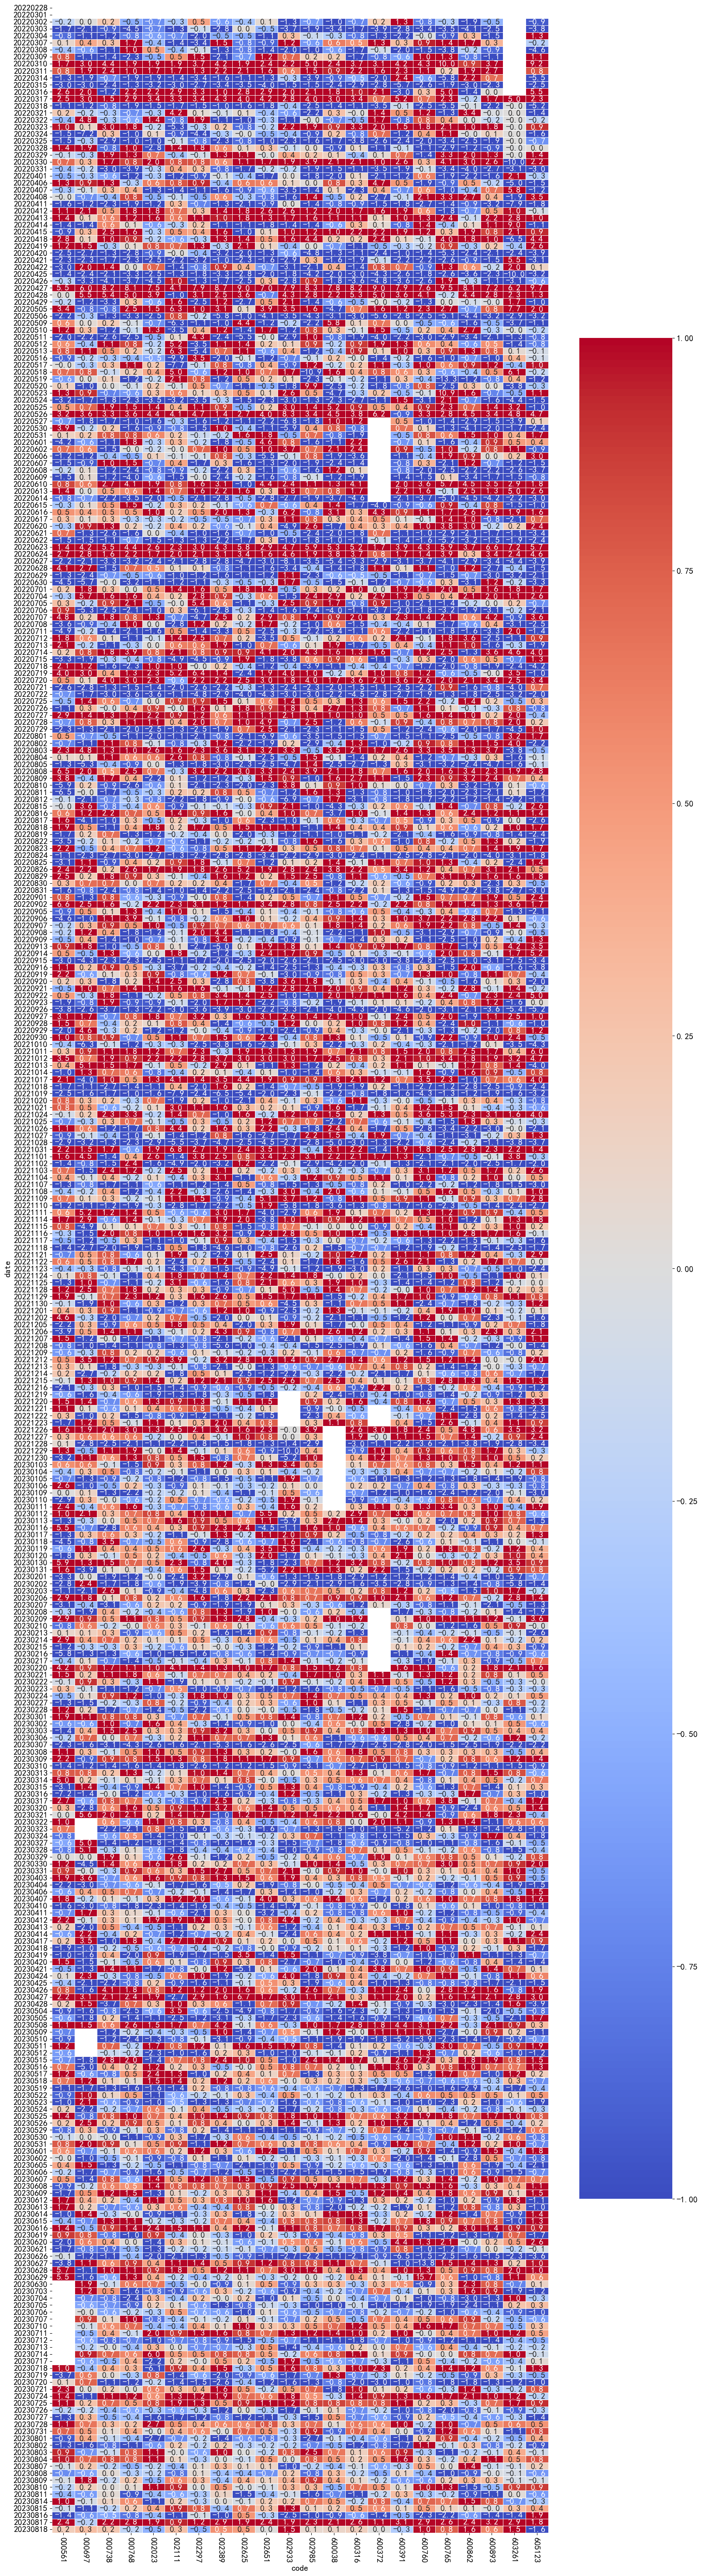

code        000561  000697  000738  000768  002023  002111  002297  002389  \
date                                                                         
2022-02-28     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2022-03-01     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2022-03-02     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2022-03-03   -1.48   -2.08   -1.14   -3.97   -0.05   -0.94   -0.57   -2.14   
2022-03-04    0.82    0.94   -0.32    3.70    0.14    0.59   -1.88    2.23   
...            ...     ...     ...     ...     ...     ...     ...     ...   
2023-08-14    1.47    0.54    0.09    1.50   -0.67    0.72    0.06   -0.10   
2023-08-15   -1.14   -1.05   -0.35   -0.35    1.50    0.76    1.03   -0.43   
2023-08-16   -1.26    0.49   -0.32   -1.02   -0.85   -2.03   -0.83   -0.63   
2023-08-17    3.81    0.39    2.77    3.60    2.32    2.04    1.30    3.93   
2023-08-18   -2.26    0.54   -2.00   -2.99   -2.36   -0.66   -1.74   -2.35   

code        002625  002651  ...  600038  600316  600372  600391  600760  \
date                        ...                                           
2022-02-28     NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN   
2022-03-01     NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN   
2022-03-02     NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN   
2022-03-03    0.39   -0.51  ...   -2.36   -1.02   -4.14   -4.04   -2.65   
2022-03-04   -0.55   -0.63  ...    3.09    0.95    2.64    0.56    3.40   
...            ...     ...  ...     ...     ...     ...     ...     ...   
2023-08-14    1.47    0.61  ...    1.20    0.88    0.92   -0.71    1.08   
2023-08-15    0.71    0.06  ...   -0.28    0.68   -0.18    0.51   -0.24   
2023-08-16   -0.14   -0.54  ...   -1.13   -1.08   -1.99   -0.61   -2.75   
2023-08-17    1.35    2.63  ...    2.99    3.19    2.47    3.59    5.17   
2023-08-18   -1.39   -2.34  ...   -1.95   -2.42   -1.04   -3.36   -1.93   

code        600765  600862  600893  603261  605123  
date                                                
2022-02-28     NaN     NaN     NaN     NaN     NaN  
2022-03-01     NaN     NaN     NaN     NaN     NaN  
2022-03-02     NaN     NaN     NaN     NaN     NaN  
2022-03-03   -3.22   -2.21   -2.05     NaN   -2.91  
2022-03-04    2.60    4.45    1.04     NaN    5.17  
...            ...     ...     ...     ...     ...  
2023-08-14    0.91    2.41    1.89   -0.68    0.30  
2023-08-15   -0.53   -1.40   -0.79    0.93    0.75  
2023-08-16   -2.32   -0.69   -1.36   -1.71    1.44  
2023-08-17    4.74    3.00    4.56    4.28   -0.08  
2023-08-18   -1.81   -0.81   -2.59   -1.36   -3.44  

[361 rows x 22 columns]

In [3]:

# block_name = '通信设备'
# block_name = '旅游景点'
# block_name = '影视音像'
# block_name = '电器仪表'
# block_name = '软件服务'
# block_name = '通信设备'
# block_name = '旅游景点'
# block_name = '影视音像'
# block_name = '电器仪表'
# block_name = '软件服务'
# block_name = '油服工程'
# block_name = '家电零部件Ⅱ'
# block_name = '化学纤维'
# block_name = '游戏Ⅱ'
# block_name = '股份制银行Ⅱ'
# block_name = '证券Ⅱ'
block_name = '航空装备Ⅱ'
hy = 'sw_l2'

stock_trend = Stock_Trend(hy_source=hy, block_name = block_name, end='2023-08-18', gap=360, frequence=QA.FREQUENCE.DAY, MA = 5)
stock_trend.fit()
stock_trend.get_trend(plot=True)

In [4]:
import tools.QAAdapter as qaadapter

import os

code_list  = qaadapter.QA_adapter_get_code_from_block(hy, block_name)
# code_list  = qaadapter.QA_adapter_get_code_from_block('tdxhy', '软件服务')

print(smpl.get_stock_name(code_list), len(code_list))

code
000561     烽火电子
000697    *ST炼石
000738     航发控制
000768     中航西飞
002023     海特高新
002111     威海广泰
002297     博云新材
002389     航天彩虹
002625     光启技术
002651     利君股份
002933     新兴装备
002985     北摩高科
600038     中直股份
600316     洪都航空
600372     中航电子
600391     航发科技
600760     中航沈飞
600765     中航重机
600862     中航高科
600893     航发动力
603261     立航科技
605123     派克新材
Name: name, dtype: object 22


In [5]:
from QUANTAXIS.QAAnalysis.QAAnalysis_finance import QAAnalysis_finance
from QUANTAXIS.QASetting.QALocalize import analysis_path
import os
# code_list = ['000408']
print("code list len ", len(code_list))
factors = ['roe', 'roa', 'profit_revenue', 'revenue_incr_rate', 'cash_incr_rate']
start = '2020-12-31'
end = '2023-03-31'
qaanalysis_finance = QAAnalysis_finance(code_list, factors,  start, end)
finance_factors = qaanalysis_finance.finance_factors_all_stock()
print(finance_factors)

csv_file = os.path.join(analysis_path, block_name + start + '_' + end + 'temp_finance_factors.csv')
finance_factors.to_csv(csv_file)

finance_rank = qaanalysis_finance.finance_factors_rank(finance_factors)

if finance_rank.empty:
  print("finance factors are None")
else:
  csv_file = os.path.join(analysis_path, block_name + start + '_' + end + '_finance.csv')
  print('finance_rank write to ', csv_file)
  finance_rank.to_csv(csv_file, index=True)

print(finance_rank)

code list len  22
no enough finance data skip stock  603261
                        roe       roa  profit_revenue  revenue_incr_rate  \
report_date code                                                           
2020-12-31  '000561   6.279  3.087112        7.949641        2249.756510   
2021-03-31  '000561  -0.957 -0.568260      -10.848366         -61.865685   
2021-06-30  '000561   0.696  0.200994        1.299393         -17.903045   
2021-09-30  '000561   0.351 -0.088401       -0.392171         -40.093636   
2021-12-31  '000561   6.495  2.937805        7.604670         710.053023   
...                     ...       ...             ...                ...   
2022-03-31  '605123   5.564  3.253014       17.584374         -20.008843   
2022-06-30  '605123  11.336  6.359809       18.232183           5.566666   
2022-09-30  '605123   9.416  6.179752       16.619589          21.826225   
2022-12-31  '605123  12.574  8.104919       17.455749         355.139533   
2023-03-31  '605123   3.579 